# Smart Medical Diagnosis System
## Enhanced Machine Learning Pipeline

This notebook implements an advanced machine learning pipeline for medical diagnosis prediction with:
- Comprehensive data preprocessing
- Feature engineering and selection
- Hyperparameter optimization
- Ensemble methods
- Cross-validation and robust evaluation

In [ ]:
# Enhanced imports for advanced ML pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import SmartPreprocessor from app.py to ensure consistent module context
import sys
sys.path.append('.')
from app import SmartPreprocessor

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [14]:
# Load and explore dataset
dataset = pd.read_csv('Training.csv')
print(f"Dataset shape: {dataset.shape}")
print(f"\nDataset info:")
print(dataset.info())
print(f"\nMissing values: {dataset.isnull().sum().sum()}")
print(f"\nUnique diseases: {dataset['prognosis'].nunique()}")

Dataset shape: (4920, 133)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB
None

Missing values: 0

Unique diseases: 41


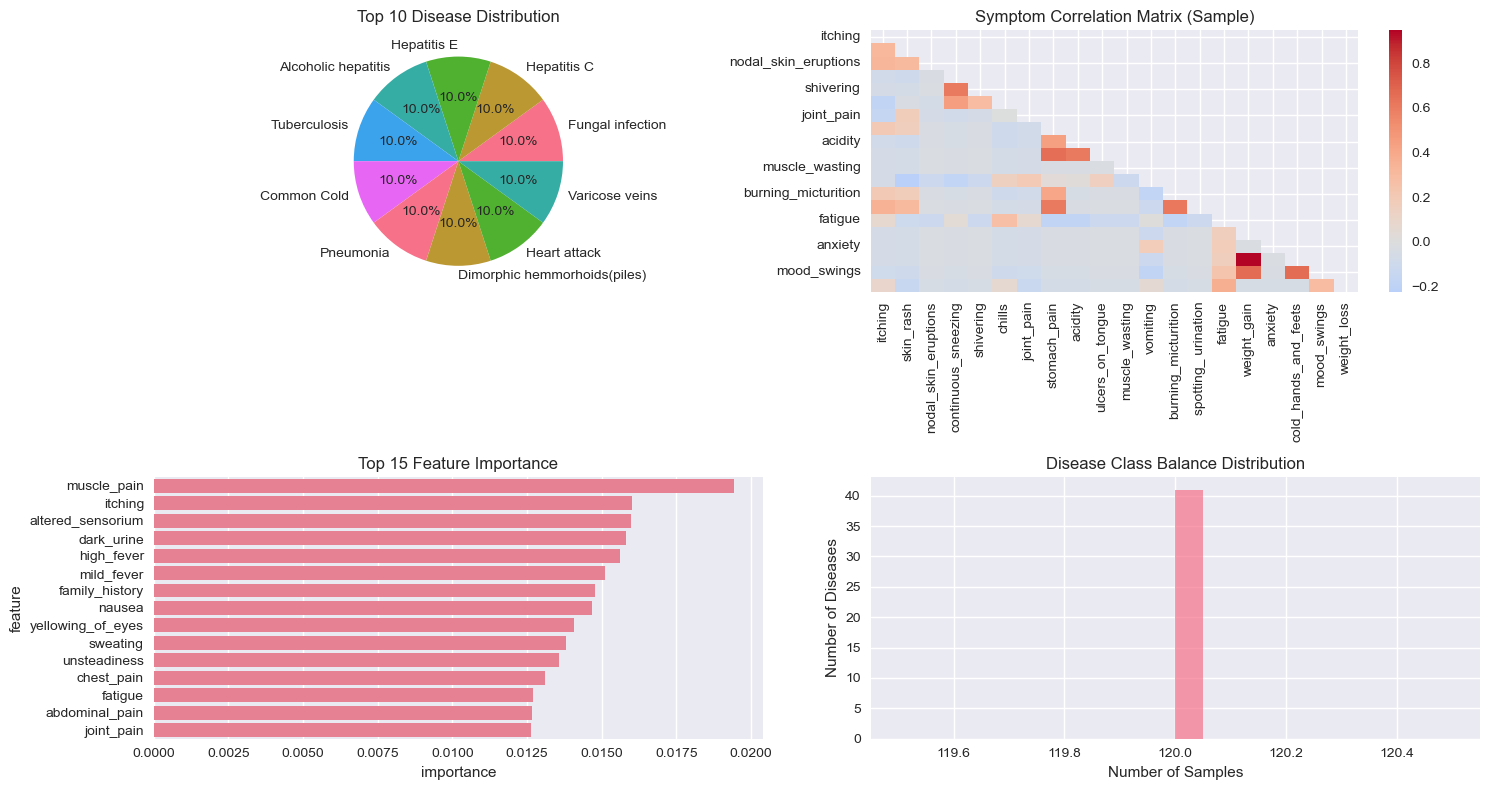

In [15]:
# Enhanced Data Analysis and Visualization
plt.figure(figsize=(15, 8))

# Disease distribution
plt.subplot(2, 2, 1)
disease_counts = dataset['prognosis'].value_counts()
plt.pie(disease_counts.head(10).values, labels=disease_counts.head(10).index, autopct='%1.1f%%')
plt.title('Top 10 Disease Distribution')

# Symptom occurrence heatmap
plt.subplot(2, 2, 2)
symptom_corr = dataset.drop('prognosis', axis=1).corr()
mask = np.triu(np.ones_like(symptom_corr, dtype=bool))
sns.heatmap(symptom_corr.iloc[:20, :20], mask=mask[:20, :20], cmap='coolwarm', center=0)
plt.title('Symptom Correlation Matrix (Sample)')

# Feature importance preview
plt.subplot(2, 2, 3)
X_temp = dataset.drop('prognosis', axis=1)
y_temp = dataset['prognosis']
le_temp = LabelEncoder()
y_encoded = le_temp.fit_transform(y_temp)
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_encoded)
feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False).head(15)
sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Top 15 Feature Importance')

# Class balance
plt.subplot(2, 2, 4)
plt.hist(disease_counts.values, bins=20, alpha=0.7)
plt.title('Disease Class Balance Distribution')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Diseases')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize preprocessing using SmartPreprocessor from app.py
X = dataset.drop('prognosis', axis=1)
y = dataset['prognosis']

preprocessor = SmartPreprocessor(feature_selection_method='mutual_info', n_features=80)
X_processed, y_encoded = preprocessor.fit_transform(X, y)

print(f"Original features: {X.shape[1]}")
print(f"Selected features: {X_processed.shape[1]}")
print(f"Selected feature names: {list(preprocessor.selected_features[:10])}...")  # Show first 10

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Original features: 132
Selected features: 80
Selected feature names: ['itching', 'skin_rash', 'continuous_sneezing', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'vomiting', 'burning_micturition', 'fatigue']...


In [17]:
# Advanced Model Configuration with Optimized Hyperparameter Tuning
def get_optimized_models():
    """Returns dictionary of models with optimized hyperparameters"""
    
    models = {}
    
    # SVM with reduced grid for speed
    svm_params = {
        'C': [1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    models['SVM'] = GridSearchCV(SVC(random_state=42), svm_params, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Random Forest - optimized grid
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    models['RandomForest'] = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Gradient Boosting - MUCH FASTER with optimized parameters
    gb_params = {
        'n_estimators': [50, 100],  # Reduced from [100, 200]
        'learning_rate': [0.1, 0.2],  # Reduced from [0.05, 0.1, 0.2]
        'max_depth': [3, 5]  # Reduced from [3, 5, 7]
    }
    models['GradientBoosting'] = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy', n_jobs=-1)
    
    # Logistic Regression - simplified
    lr_params = {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [1000]
    }
    models['LogisticRegression'] = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=3, scoring='accuracy', n_jobs=-1)
    
    # K-Nearest Neighbors - reduced grid
    knn_params = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    models['KNN'] = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='accuracy', n_jobs=-1)
    
    return models

# Train and evaluate models
print("Training optimized models with hyperparameter tuning...")
models = get_optimized_models()
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Get best parameters
    print(f"Best parameters for {name}: {model.best_params_}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Comprehensive evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation score
    cv_scores = cross_val_score(model.best_estimator_, X_train, y_train, cv=5)
    
    results[name] = {
        'model': model.best_estimator_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': model.best_params_
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training optimized models with hyperparameter tuning...

Training SVM...
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.9919
CV Score: 0.9939 (+/- 0.0044)

Training RandomForest...
Accuracy: 0.9919
CV Score: 0.9939 (+/- 0.0044)

Training RandomForest...
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9929
CV Score: 0.9944 (+/- 0.0057)

Training GradientBoosting...
Accuracy: 0.9929
CV Score: 0.9944 (+/- 0.0057)

Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.9919
CV Score: 0.9921 (+/- 0.0061)

T

In [ ]:
# Advanced Ensemble Methods
print("\nCreating Advanced Ensemble Models...")

# Get top 3 performing models for ensemble
top_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:3]
print(f"Top 3 models: {[name for name, _ in top_models]}")

# Voting Classifier (Hard and Soft voting)
voting_models = [(name, info['model']) for name, info in top_models]

# Hard Voting
hard_voting = VotingClassifier(estimators=voting_models, voting='hard')
hard_voting.fit(X_train, y_train)
hard_pred = hard_voting.predict(X_test)
hard_accuracy = accuracy_score(y_test, hard_pred)

# Soft Voting
soft_voting = VotingClassifier(estimators=voting_models, voting='soft')
soft_voting.fit(X_train, y_train)
soft_pred = soft_voting.predict(X_test)
soft_accuracy = accuracy_score(y_test, soft_pred)

# Stacking Ensemble
from sklearn.ensemble import StackingClassifier
stacking = StackingClassifier(
    estimators=voting_models,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking.fit(X_train, y_train)
stacking_pred = stacking.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)

# Add ensemble results
results['HardVoting'] = {
    'model': hard_voting,
    'accuracy': hard_accuracy,
    'precision': precision_score(y_test, hard_pred, average='weighted'),
    'recall': recall_score(y_test, hard_pred, average='weighted'),
    'f1_score': f1_score(y_test, hard_pred, average='weighted')
}

results['SoftVoting'] = {
    'model': soft_voting,
    'accuracy': soft_accuracy,
    'precision': precision_score(y_test, soft_pred, average='weighted'),
    'recall': recall_score(y_test, soft_pred, average='weighted'),
    'f1_score': f1_score(y_test, soft_pred, average='weighted')
}

results['Stacking'] = {
    'model': stacking,
    'accuracy': stacking_accuracy,
    'precision': precision_score(y_test, stacking_pred, average='weighted'),
    'recall': recall_score(y_test, stacking_pred, average='weighted'),
    'f1_score': f1_score(y_test, stacking_pred, average='weighted')
}

print(f"\nEnsemble Results:")
print(f"Hard Voting Accuracy: {hard_accuracy:.4f}")
print(f"Soft Voting Accuracy: {soft_accuracy:.4f}")
print(f"Stacking Accuracy: {stacking_accuracy:.4f}")


Creating Advanced Ensemble Models...
Top 3 models: ['RandomForest', 'LogisticRegression', 'KNN']

Ensemble Results:
Hard Voting Accuracy: 0.9929
Soft Voting Accuracy: 0.9929
Stacking Accuracy: 0.9919


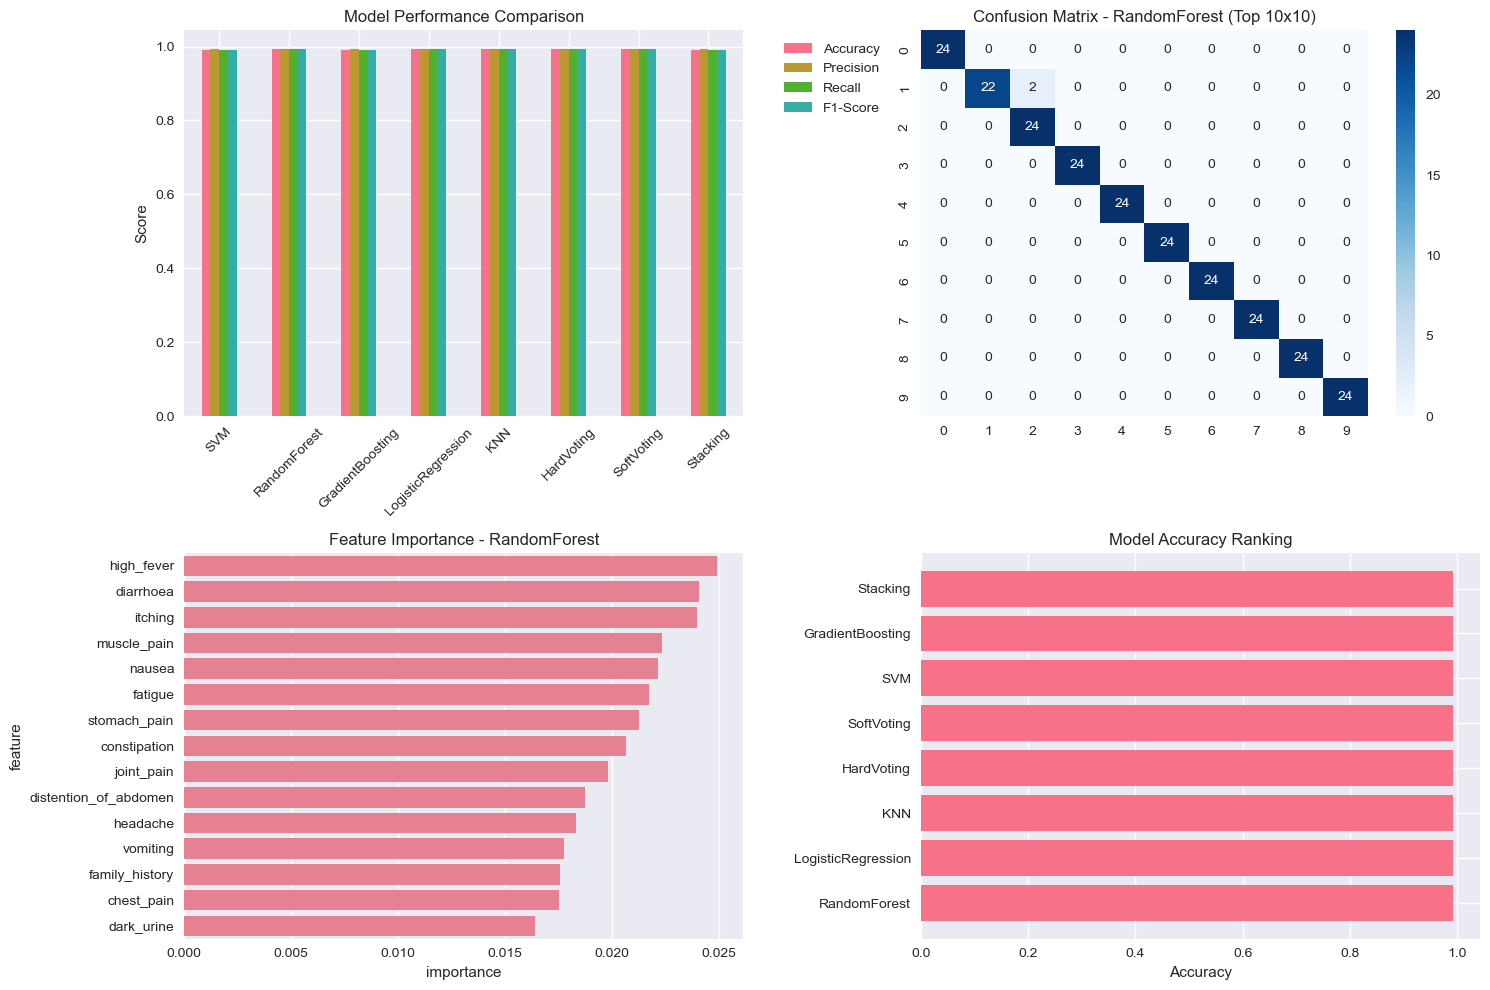


COMPREHENSIVE MODEL EVALUATION RESULTS

RandomForest:
  Accuracy:  0.9929
  Precision: 0.9939
  Recall:    0.9929
  F1-Score:  0.9930
  CV Score:  0.9944 (+/- 0.0029)

LogisticRegression:
  Accuracy:  0.9929
  Precision: 0.9934
  Recall:    0.9929
  F1-Score:  0.9929
  CV Score:  0.9942 (+/- 0.0026)

KNN:
  Accuracy:  0.9929
  Precision: 0.9939
  Recall:    0.9929
  F1-Score:  0.9930
  CV Score:  0.9942 (+/- 0.0030)

HardVoting:
  Accuracy:  0.9929
  Precision: 0.9939
  Recall:    0.9929
  F1-Score:  0.9930

SoftVoting:
  Accuracy:  0.9929
  Precision: 0.9939
  Recall:    0.9929
  F1-Score:  0.9930

SVM:
  Accuracy:  0.9919
  Precision: 0.9926
  Recall:    0.9919
  F1-Score:  0.9919
  CV Score:  0.9939 (+/- 0.0022)

GradientBoosting:
  Accuracy:  0.9919
  Precision: 0.9926
  Recall:    0.9919
  F1-Score:  0.9919
  CV Score:  0.9921 (+/- 0.0031)

Stacking:
  Accuracy:  0.9919
  Precision: 0.9926
  Recall:    0.9919
  F1-Score:  0.9919


In [ ]:
# Comprehensive Results Visualization and Analysis
results_df = pd.DataFrame({
    name: [info['accuracy'], info['precision'], info['recall'], info['f1_score']]
    for name, info in results.items()
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

plt.figure(figsize=(15, 10))

# Performance comparison
plt.subplot(2, 2, 1)
results_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Best model confusion matrix
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
best_pred = best_model.predict(X_test)

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues')  # Show only first 10x10 for visibility
plt.title(f'Confusion Matrix - {best_model_name} (Top 10x10)')

# Feature importance for best model (if available)
plt.subplot(2, 2, 3)
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': preprocessor.selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    sns.barplot(data=feature_imp, y='feature', x='importance')
    plt.title(f'Feature Importance - {best_model_name}')
else:
    plt.text(0.5, 0.5, f'{best_model_name}\ndoes not have\nfeature_importances_', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance Not Available')

# Model accuracy ranking
plt.subplot(2, 2, 4)
accuracy_scores = {name: info['accuracy'] for name, info in results.items()}
sorted_models = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)
models_names, accuracies = zip(*sorted_models)
plt.barh(models_names, accuracies)
plt.title('Model Accuracy Ranking')
plt.xlabel('Accuracy')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*50)
print("COMPREHENSIVE MODEL EVALUATION RESULTS")
print("="*50)
for name, info in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"\n{name}:")
    print(f"  Accuracy:  {info['accuracy']:.4f}")
    print(f"  Precision: {info['precision']:.4f}")
    print(f"  Recall:    {info['recall']:.4f}")
    print(f"  F1-Score:  {info['f1_score']:.4f}")
    if 'cv_mean' in info:
        print(f"  CV Score:  {info['cv_mean']:.4f} (+/- {info['cv_std']:.4f})")

In [ ]:
# Save the best model and preprocessing pipeline
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Best model accuracy: {results[best_model_name]['accuracy']:.4f}")

# Save model and preprocessor with proper module context
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
    
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Also save the traditional SVC for compatibility
svc_model = None
if 'SVM' in results:
    svc_model = results['SVM']['model']
else:
    # Fallback: train a simple SVC
    svc_model = SVC(kernel='linear', random_state=42)
    svc_model.fit(X_train, y_train)

with open('svc.pkl', 'wb') as f:
    pickle.dump(svc_model, f)

print("\nModels saved successfully!")
print("- best_model.pkl: Best performing model")
print("- preprocessor.pkl: Data preprocessing pipeline")
print("- svc.pkl: SVC model for compatibility")


Best performing model: RandomForest
Best model accuracy: 0.9929

Models saved successfully!
- best_model.pkl: Best performing model
- preprocessor.pkl: Data preprocessing pipeline
- svc.pkl: SVC model for compatibility


In [21]:
# Enhanced prediction system with confidence scoring
class SmartDiagnosisSystem:
    def __init__(self, model_path='best_model.pkl', preprocessor_path='preprocessor.pkl'):
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        with open(preprocessor_path, 'rb') as f:
            self.preprocessor = pickle.load(f)
        
        # Load supporting data
        self.symptoms_dict = {'itching': 0, 'skin_rash': 1, 'nodal_skin_eruptions': 2, 'continuous_sneezing': 3, 'shivering': 4, 'chills': 5, 'joint_pain': 6, 'stomach_pain': 7, 'acidity': 8, 'ulcers_on_tongue': 9, 'muscle_wasting': 10, 'vomiting': 11, 'burning_micturition': 12, 'spotting_ urination': 13, 'fatigue': 14, 'weight_gain': 15, 'anxiety': 16, 'cold_hands_and_feets': 17, 'mood_swings': 18, 'weight_loss': 19, 'restlessness': 20, 'lethargy': 21, 'patches_in_throat': 22, 'irregular_sugar_level': 23, 'cough': 24, 'high_fever': 25, 'sunken_eyes': 26, 'breathlessness': 27, 'sweating': 28, 'dehydration': 29, 'indigestion': 30, 'headache': 31, 'yellowish_skin': 32, 'dark_urine': 33, 'nausea': 34, 'loss_of_appetite': 35, 'pain_behind_the_eyes': 36, 'back_pain': 37, 'constipation': 38, 'abdominal_pain': 39, 'diarrhoea': 40, 'mild_fever': 41, 'yellow_urine': 42, 'yellowing_of_eyes': 43, 'acute_liver_failure': 44, 'fluid_overload': 45, 'swelling_of_stomach': 46, 'swelled_lymph_nodes': 47, 'malaise': 48, 'blurred_and_distorted_vision': 49, 'phlegm': 50, 'throat_irritation': 51, 'redness_of_eyes': 52, 'sinus_pressure': 53, 'runny_nose': 54, 'congestion': 55, 'chest_pain': 56, 'weakness_in_limbs': 57, 'fast_heart_rate': 58, 'pain_during_bowel_movements': 59, 'pain_in_anal_region': 60, 'bloody_stool': 61, 'irritation_in_anus': 62, 'neck_pain': 63, 'dizziness': 64, 'cramps': 65, 'bruising': 66, 'obesity': 67, 'swollen_legs': 68, 'swollen_blood_vessels': 69, 'puffy_face_and_eyes': 70, 'enlarged_thyroid': 71, 'brittle_nails': 72, 'swollen_extremeties': 73, 'excessive_hunger': 74, 'extra_marital_contacts': 75, 'drying_and_tingling_lips': 76, 'slurred_speech': 77, 'knee_pain': 78, 'hip_joint_pain': 79, 'muscle_weakness': 80, 'stiff_neck': 81, 'swelling_joints': 82, 'movement_stiffness': 83, 'spinning_movements': 84, 'loss_of_balance': 85, 'unsteadiness': 86, 'weakness_of_one_body_side': 87, 'loss_of_smell': 88, 'bladder_discomfort': 89, 'foul_smell_of urine': 90, 'continuous_feel_of_urine': 91, 'passage_of_gases': 92, 'internal_itching': 93, 'toxic_look_(typhos)': 94, 'depression': 95, 'irritability': 96, 'muscle_pain': 97, 'altered_sensorium': 98, 'red_spots_over_body': 99, 'belly_pain': 100, 'abnormal_menstruation': 101, 'dischromic _patches': 102, 'watering_from_eyes': 103, 'increased_appetite': 104, 'polyuria': 105, 'family_history': 106, 'mucoid_sputum': 107, 'rusty_sputum': 108, 'lack_of_concentration': 109, 'visual_disturbances': 110, 'receiving_blood_transfusion': 111, 'receiving_unsterile_injections': 112, 'coma': 113, 'stomach_bleeding': 114, 'distention_of_abdomen': 115, 'history_of_alcohol_consumption': 116, 'fluid_overload.1': 117, 'blood_in_sputum': 118, 'prominent_veins_on_calf': 119, 'palpitations': 120, 'painful_walking': 121, 'pus_filled_pimples': 122, 'blackheads': 123, 'scurring': 124, 'skin_peeling': 125, 'silver_like_dusting': 126, 'small_dents_in_nails': 127, 'inflammatory_nails': 128, 'blister': 129, 'red_sore_around_nose': 130, 'yellow_crust_ooze': 131}
        self.diseases_list = {15: 'Fungal infection', 4: 'Allergy', 16: 'GERD', 9: 'Chronic cholestasis', 14: 'Drug Reaction', 33: 'Peptic ulcer diseae', 1: 'AIDS', 12: 'Diabetes ', 17: 'Gastroenteritis', 6: 'Bronchial Asthma', 23: 'Hypertension ', 30: 'Migraine', 7: 'Cervical spondylosis', 32: 'Paralysis (brain hemorrhage)', 28: 'Jaundice', 29: 'Malaria', 8: 'Chicken pox', 11: 'Dengue', 37: 'Typhoid', 40: 'hepatitis A', 19: 'Hepatitis B', 20: 'Hepatitis C', 21: 'Hepatitis D', 22: 'Hepatitis E', 3: 'Alcoholic hepatitis', 36: 'Tuberculosis', 10: 'Common Cold', 34: 'Pneumonia', 13: 'Dimorphic hemmorhoids(piles)', 18: 'Heart attack', 39: 'Varicose veins', 26: 'Hypothyroidism', 24: 'Hyperthyroidism', 25: 'Hypoglycemia', 31: 'Osteoarthristis', 5: 'Arthritis', 0: '(vertigo) Paroymsal  Positional Vertigo', 2: 'Acne', 38: 'Urinary tract infection', 35: 'Psoriasis', 27: 'Impetigo'}
    
    def predict_with_confidence(self, patient_symptoms):
        """Enhanced prediction with confidence scoring and top-k results"""
        # Create input vector
        input_vector = np.zeros(len(self.symptoms_dict))
        valid_symptoms = []
        
        for symptom in patient_symptoms:
            if symptom in self.symptoms_dict:
                input_vector[self.symptoms_dict[symptom]] = 1
                valid_symptoms.append(symptom)
        
        if len(valid_symptoms) == 0:
            return None, 0.0, [], []
        
        # Create DataFrame for preprocessing
        input_df = pd.DataFrame([input_vector], columns=list(self.symptoms_dict.keys()))
        
        # Preprocess
        input_processed = self.preprocessor.transform(input_df)
        
        # Get prediction
        prediction = self.model.predict(input_processed)[0]
        predicted_disease = self.diseases_list[prediction]
        
        # Get confidence (probability) if available
        confidence = 0.0
        top_diseases = []
        
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(input_processed)[0]
            confidence = probabilities[prediction]
            
            # Get top 3 predictions
            top_indices = np.argsort(probabilities)[-3:][::-1]
            top_diseases = [(self.diseases_list[idx], probabilities[idx]) for idx in top_indices]
        
        return predicted_disease, confidence, valid_symptoms, top_diseases

# Test the enhanced system
print("\nTesting Enhanced Diagnosis System...")
diagnosis_system = SmartDiagnosisSystem()

# Test case
test_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
prediction, confidence, valid_symptoms, top_diseases = diagnosis_system.predict_with_confidence(test_symptoms)

print(f"\nTest Symptoms: {test_symptoms}")
print(f"Valid Symptoms: {valid_symptoms}")
print(f"Predicted Disease: {prediction}")
print(f"Confidence: {confidence:.4f}")
if top_diseases:
    print("\nTop 3 Predictions:")
    for i, (disease, prob) in enumerate(top_diseases, 1):
        print(f"  {i}. {disease}: {prob:.4f}")


Testing Enhanced Diagnosis System...

Test Symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions']
Valid Symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions']
Predicted Disease: Fungal infection
Confidence: 0.5475

Top 3 Predictions:
  1. Fungal infection: 0.5475
  2. Acne: 0.1004
  3. Drug Reaction: 0.0373


In [1]:
# Interactive Enhanced Testing
def enhanced_diagnosis_test():
    """Interactive testing with enhanced features"""
    print("\n" + "="*60)
    print("ENHANCED MEDICAL DIAGNOSIS SYSTEM - INTERACTIVE TEST")
    print("="*60)
    
    # Load supporting data
    try:
        sym_des = pd.read_csv("symtoms_df.csv")
        precautions = pd.read_csv("precautions_df.csv")
        workout = pd.read_csv("workout_df.csv")
        description = pd.read_csv("description.csv")
        medications = pd.read_csv('medications.csv')
        diets = pd.read_csv("diets.csv")
    except FileNotFoundError as e:
        print(f"Warning: Could not load supporting data files: {e}")
        return
    
    def get_disease_info(predicted_disease):
        """Get comprehensive disease information"""
        try:
            desc = description[description['Disease'] == predicted_disease]['Description']
            desc = " ".join([w for w in desc]) if not desc.empty else "Description not available"

            pre = precautions[precautions['Disease'] == predicted_disease][['Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']]
            pre = [col for col in pre.values] if not pre.empty else [["No precautions available"]]

            med = medications[medications['Disease'] == predicted_disease]['Medication']
            med = [m for m in med.values] if not med.empty else ["No medications available"]

            die = diets[diets['Disease'] == predicted_disease]['Diet']
            die = [d for d in die.values] if not die.empty else ["No diet information available"]

            wrkout = workout[workout['disease'] == predicted_disease]['workout']
            wrkout = [w for w in wrkout.values] if not wrkout.empty else ["No workout information available"]

            return desc, pre, med, die, wrkout
        except Exception as e:
            print(f"Error getting disease info: {e}")
            return "Error", [["Error"]], ["Error"], ["Error"], ["Error"]
    
    # Interactive loop
    while True:
        symptoms_input = input("\nEnter symptoms (comma-separated) or 'quit' to exit: ")
        
        if symptoms_input.lower() == 'quit':
            break
            
        # Process symptoms
        user_symptoms = [s.strip() for s in symptoms_input.split(',')]
        user_symptoms = [symptom.strip("[]' \"") for symptom in user_symptoms]
        
        # Get prediction
        prediction, confidence, valid_symptoms, top_diseases = diagnosis_system.predict_with_confidence(user_symptoms)
        
        if prediction is None:
            print("\n❌ No valid symptoms found. Please check your input.")
            continue
        
        # Display results
        print("\n" + "="*50)
        print("📊 DIAGNOSIS RESULTS")
        print("="*50)
        print(f"🔍 Input Symptoms: {', '.join(user_symptoms)}")
        print(f"✅ Valid Symptoms: {', '.join(valid_symptoms)}")
        print(f"🏥 Predicted Disease: {prediction}")
        print(f"📈 Confidence: {confidence:.2%}")
        
        if top_diseases:
            print("\n🏆 Top 3 Predictions:")
            for i, (disease, prob) in enumerate(top_diseases, 1):
                print(f"   {i}. {disease}: {prob:.2%}")
        
        # Get detailed information
        desc, pre, med, die, wrkout = get_disease_info(prediction)
        
        print("\n" + "="*50)
        print("📋 DETAILED INFORMATION")
        print("="*50)
        
        print(f"\n📖 Description:")
        print(f"   {desc}")
        
        print(f"\n⚠️  Precautions:")
        for i, p in enumerate(pre[0] if pre else [], 1):
            if p and p != "No precautions available":
                print(f"   {i}. {p}")
        
        print(f"\n💊 Recommended Medications:")
        for i, m in enumerate(med, 1):
            if m and m != "No medications available":
                print(f"   {i}. {m}")
        
        print(f"\n🏃‍♂️ Suggested Workouts:")
        for i, w in enumerate(wrkout, 1):
            if w and w != "No workout information available":
                print(f"   {i}. {w}")
        
        print(f"\n🥗 Recommended Diet:")
        for i, d in enumerate(die, 1):
            if d and d != "No diet information available":
                print(f"   {i}. {d}")
        
        print("\n" + "="*50)
        print("⚠️  DISCLAIMER: This is for educational purposes only.")
        print("   Always consult a healthcare professional for medical advice.")
        print("="*50)

# Run the enhanced interactive test
enhanced_diagnosis_test()


ENHANCED MEDICAL DIAGNOSIS SYSTEM - INTERACTIVE TEST


NameError: name 'pd' is not defined